# Statistics

This notebook shows how the statistics are performed across subjects.

A unique statistics procedure was used across all analyses, and consisted in performing a 2nd order spatio-temporal cluster analysis across the effect size estimated within each subject.

# Prepare data & functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mne import EpochsArray
from mne.io.meas_info import create_info
from mne.stats import spatio_temporal_cluster_1samp_test
from mne.decoding import GeneralizationAcrossTime

from sklearn.metrics import roc_auc_score

In [2]:
n_subject, n_trial, n_chan, n_time = 10, 40, 20, 50

def make_data(y, topography, snr=.25):
    """Simulate `n_trials` measured at sensor level in a given subject."""
    X = np.zeros((n_trial, n_chan, n_time))
    
    # Add projection to sensors for each trial between start and stop
    # Note that this is a stable activation (unique forward and source models)
    start, stop = 10, n_time - 10
    for time in range(start, stop):
        X[:, :, time] += np.dot(topography, y[:, None].T).T

    # Add background noise
    X += np.random.randn(*X.shape) / snr
    
    # Format MEG data into MNE-Python object
    events = np.vstack((range(n_trial), np.zeros(n_trial, int), y)).T
    chan_names = ['MEG %i' % chan for chan in range(n_chan)]
    chan_types = ['mag'] * n_chan
    sfreq = 250
    info = create_info(chan_names, sfreq, chan_types)
    epochs = EpochsArray(data=X, info=info, events=events, verbose=False)
    return epochs


def stats(X):
    """Statistical test applied across subjects"""
    # check input
    X = np.array(X)
    X = X[:, :, None] if X.ndim == 2 else X
    
    # stats function report p_value for each cluster
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
        X, out_type='mask', n_permutations=2**12, n_jobs=-1, verbose=False)
    
    # format p_values to get same dimensionality as X
    p_values_ = np.ones_like(X[0]).T
    for cluster, pval in zip(clusters, p_values):
        p_values_[cluster.T] = pval

    return np.squeeze(p_values_).T


def scorer(y_true, y_pred):
    """Proxy for effect size estimate, should it be uni- or multivariate"""
    y_pred = y_pred[:, 1] if y_pred.ndim == 2 else y_pred  # ensure dimensionality
    return roc_auc_score(y_true, y_pred)

# Univariate stats

('subject:', 0)
('subject:', 1)
('subject:', 2)
('subject:', 3)
('subject:', 4)
('subject:', 5)
('subject:', 6)
('subject:', 7)
('subject:', 8)
('subject:', 9)
('shape:', (10, 20, 50))


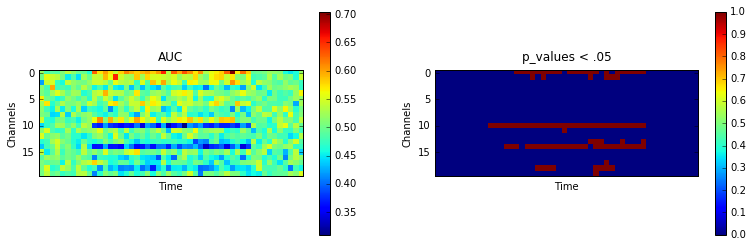

In [3]:
# Simulate univariate subject scores.
# Univariate stats can only see effects that are common across subjects, so the topography
# must be relatively similar across subjects
topography = np.random.randn(n_chan, 1)


subjects_score = []
for subject in range(n_subject):
    print('subject:', subject)
    
    # Simulate epochs
    y = np.random.randint(0, 2, n_trial)
    epochs = make_data(y, topography=topography)
    
    # Estimate effect size for each channel at each time point
    score = np.zeros((n_chan, n_time))
    for chan in range(n_chan):
        for time in range(n_time):
            score[chan, time] = scorer(y, epochs._data[:, chan, time])
    
    # Concatenate single subject effect sizes
    subjects_score.append(score)

# Compute stats
print('shape:', np.shape(subjects_score))
chance = .5
p_values = stats(np.array(subjects_score) - chance)

# Plot mean effect size, and cluster corrected significant time/chan points
fig, (ax_score, ax_pval) = plt.subplots(1, 2, figsize=[13, 4])
im = ax_score.matshow(np.mean(subjects_score, axis=0))
ax_score.set_xlabel('Time')
ax_score.set_ylabel('Channels')
ax_score.set_title('AUC')
ax_score.set_xticks([])
plt.colorbar(im, ax=ax_score)

im = ax_pval.matshow(p_values < .05)
ax_pval.set_xlabel('Time')
ax_pval.set_ylabel('Channels')
ax_pval.set_xticks([])
ax_pval.set_title('p_values < .05')
plt.colorbar(im, ax=ax_pval)
plt.show()

# Multivariate stats

('subject:', 0)
('subject:', 1)
('subject:', 2)
('subject:', 3)
('subject:', 4)
('subject:', 5)
('subject:', 6)
('subject:', 7)
('subject:', 8)
('subject:', 9)


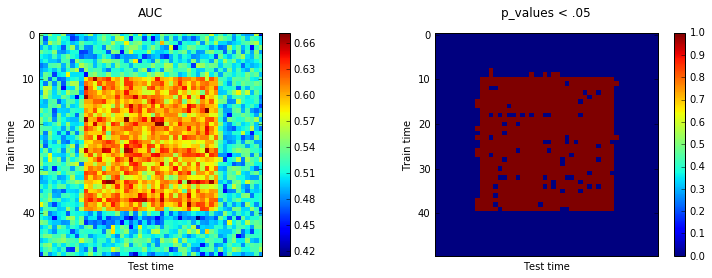

In [4]:
# Simulate subject scores
subjects_score = []
for subject in range(n_subject):
    print('subject:', subject)
    
    # Multivariate stats can see effects that are different across subjects.
    # The coding topography may therefore vary.
    topography = np.random.randn(n_chan, 1)

    # Simulate epochs
    y = np.random.randint(0, 2, n_trial)
    epochs = make_data(y, topography=topography)
    
    # Fit (default: standard scaler + logistic regression)
    gat = GeneralizationAcrossTime(scorer=scorer)
    gat.fit(epochs)
    
    # Score (default: accuracy)
    score = gat.score(epochs)
    
    # Append multivariate effect size across subjects
    subjects_score.append(score)

# Here chance level is .5 (because it's a categorical decision, and n_class=2)
chance = .5
p_values = stats(np.array(subjects_score) - chance)


# Plot mean effect size, and cluster corrected significant time points
fig, (ax_score, ax_pval) = plt.subplots(1, 2, figsize=[13, 4])
im = ax_score.matshow(np.mean(subjects_score, axis=0))
ax_score.set_xlabel('Test time')
ax_score.set_ylabel('Train time')
ax_score.set_title('AUC')
ax_score.set_xticks([])
plt.colorbar(im, ax=ax_score)

im = ax_pval.matshow(p_values < .05)
ax_pval.set_xlabel('Test time')
ax_pval.set_ylabel('Train time')
ax_pval.set_xticks([])
ax_pval.set_title('p_values < .05')
plt.colorbar(im, ax=ax_pval)
plt.show()